Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain, LinearAlgebra
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);
first(df2, 5)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0


Use data from m4.1s

Check if the m4.1s.jls file is present. If not, run the model.

In [5]:
!isfile(joinpath(ProjDir, "m4.1s.jls")) && include(joinpath(ProjDir, "m4.1s.jl"))

chn = deserialize(joinpath(ProjDir, "m4.1s.jls"))

Object of type "Chains{Float64}"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Union{Missing, Float64}[7.67355 154.541; 7.8199 154.67; … ; 7.21526 154.312; 7.1476 154.348]

Union{Missing, Float64}[8.29156 154.352; 7.47498 154.355; … ; 7.5685 153.594; 7.65284 153.572]

Union{Missing, Float64}[8.03053 155.004; 7.29587 154.228; … ; 7.67892 154.55; 8.04259 155.297]

Union{Missing, Float64}[8.10731 155.077; 7.60446 154.942; … ; 8.25667 153.945; 7.98107 154.498]

Describe the draws

In [6]:
describe(chn)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
         Mean        SD       Naive SE      MCSE      ESS
sigma   7.776144 0.29344701 0.004639805 0.0051769364 1000
   mu 154.608564 0.40948250 0.006474487 0.0073322535 1000

Quantiles:
         2.5%       25.0%      50.0%      75.0%      97.5%  
sigma   7.240897   7.5645725   7.76619   7.965735   8.387369
   mu 153.789975 154.3430000 154.60250 154.881000 155.418025



Plot the density of posterior draws

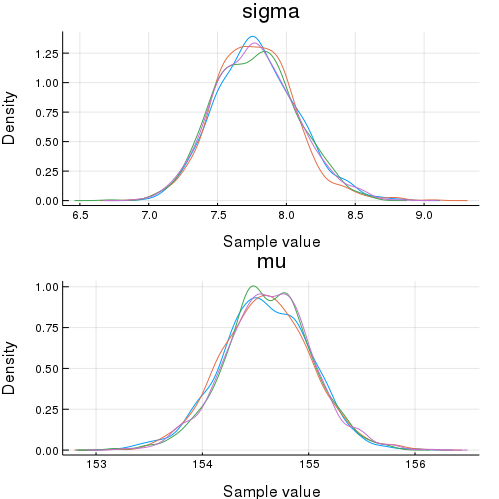

In [7]:
density(chn, lab="All heights", xlab="height [cm]", ylab="density")

Compute cor

In [8]:
mu_sigma = hcat(chn.value[:, 2, 1], chn.value[:,1, 1])
LinearAlgebra.diag(cov(mu_sigma))

2-element Array{Float64,1}:
 0.1735488528528528 
 0.08748354475150744

Compute cov

In [9]:
cor(mu_sigma)

2×2 Array{Float64,2}:
  1.0        -0.0165632
 -0.0165632   1.0      

End of `clip_07.0s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*